# DATA PREPROCESSING :
- Converting the text files to csv
- Dropping the columns with negligible variance, to reduce noise
- Finding the RUL at each time stamp for each engine
- Finding a threshold RUL to be considered as 'Healthy'
- Normalize the training dataset to feed into the LSTM

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [5]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]

# Converting the FD001 text files to csv :
col_names = index_names + setting_names + sensor_names
df_train = pd.read_csv('train_FD001.txt', delim_whitespace = True, header = None, names = col_names)
print(df_train.head())
print(df_train.shape)
df_train.to_csv('train_FD001.csv', index = False)
df_test = pd.read_csv('test_FD001.txt', delim_whitespace = True, header = None, names = col_names)
df_test.to_csv('test_FD001.csv', index = False)
df_RUL  = pd.read_csv('RUL_FD001.txt', delim_whitespace = True, header = None, names = ['RUL'])
df_RUL.to_csv('RUL_FD001.csv', index = False)

/tmp/ipython-input-569032710.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_train = pd.read_csv('train_FD001.txt', delim_whitespace = True, header = None, names = col_names)


   unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1        1            2     0.0019    -0.0003      100.0  518.67  642.15   
2        1            3    -0.0043     0.0003      100.0  518.67  642.35   
3        1            4     0.0007     0.0000      100.0  518.67  642.35   
4        1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03   393   

   s_18   s_19   s_20     s_21  
0  2388  100.0  39.06  

/tmp/ipython-input-569032710.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv('test_FD001.txt', delim_whitespace = True, header = None, names = col_names)
/tmp/ipython-input-569032710.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_RUL  = pd.read_csv('RUL_FD001.txt', delim_whitespace = True, header = None, names = ['RUL'])


In [6]:
# Adding the RUL column for the test data and dropping the columns with negligble variance
df_train = pd.read_csv('train_FD001.csv')
df_test = pd.read_csv('test_FD001.csv')
df_train['max'] = df_train.groupby('unit_nr')['time_cycles'].transform('max')
df_train['RUL'] = df_train['max'] - df_train['time_cycles']
df_train.drop('max', axis = 1, inplace = True)
variance = df_train.var()
variance1 = df_test.var()
threshold = 1e-5
df_train = df_train.loc[:, variance > threshold]
df_test = df_test.loc[:, variance1 > threshold]
print(df_train.head())
print(df_test.head())

   unit_nr  time_cycles     s_2      s_3      s_4     s_7      s_8      s_9  \
0        1            1  641.82  1589.70  1400.60  554.36  2388.06  9046.19   
1        1            2  642.15  1591.82  1403.14  553.75  2388.04  9044.07   
2        1            3  642.35  1587.99  1404.20  554.26  2388.08  9052.94   
3        1            4  642.35  1582.79  1401.87  554.45  2388.11  9049.48   
4        1            5  642.37  1582.85  1406.22  554.00  2388.06  9055.15   

    s_11    s_12     s_13     s_14    s_15  s_17   s_20     s_21  RUL  
0  47.47  521.66  2388.02  8138.62  8.4195   392  39.06  23.4190  191  
1  47.49  522.28  2388.07  8131.49  8.4318   392  39.00  23.4236  190  
2  47.27  522.42  2388.03  8133.23  8.4178   390  38.95  23.3442  189  
3  47.13  522.86  2388.08  8133.83  8.3682   392  38.88  23.3739  188  
4  47.28  522.19  2388.04  8133.80  8.4294   393  38.90  23.4044  187  
   unit_nr  time_cycles     s_2      s_3      s_4     s_7      s_8      s_9  \
0        1    

In [7]:
df1 = df_train.drop(['unit_nr', 'time_cycles'], axis = 1)
correlations = df1.corrwith(df1['RUL']).abs()
top_sensors = correlations.sort_values(ascending = False)
print(top_sensors)

RUL     1.000000
s_11    0.696228
s_4     0.678948
s_12    0.671983
s_7     0.657223
s_15    0.642667
s_21    0.635662
s_20    0.629428
s_2     0.606484
s_17    0.606154
s_3     0.584520
s_8     0.563968
s_13    0.562569
s_9     0.390102
s_14    0.306769
dtype: float64


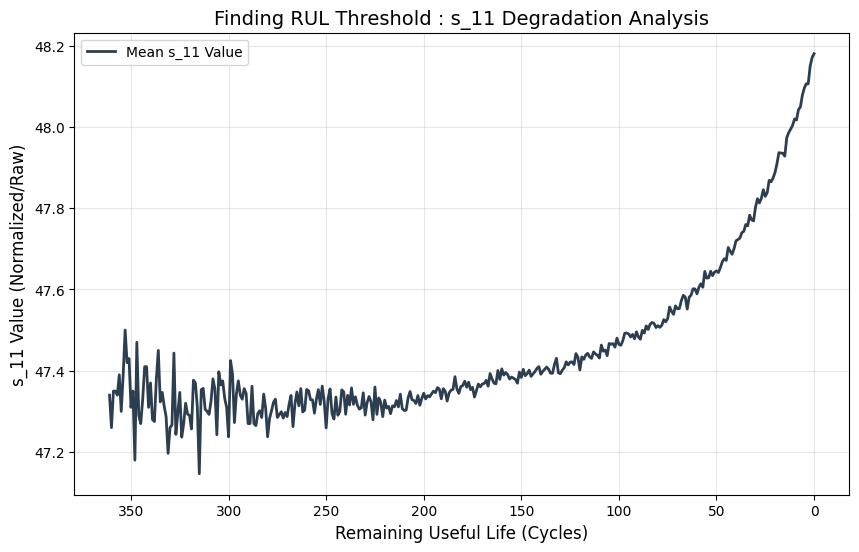

In [8]:
sensor = 's_11'
fleet_life = df_train.groupby('RUL')[sensor].mean()
plt.figure(figsize = (10, 6))
plt.plot(fleet_life.index, fleet_life.values, color='#2c3e50', linewidth=2, label=f'Mean {sensor} Value')
plt.gca().invert_xaxis()

plt.title(f'Finding RUL Threshold : {sensor} Degradation Analysis', fontsize=14)
plt.xlabel('Remaining Useful Life (Cycles)', fontsize=12)
plt.ylabel(f'{sensor} Value (Normalized/Raw)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [9]:
# Choosing 125 as the RUL threshold
threshold = 125
df_train['RUL'] = df_train['RUL'].clip(upper=threshold)
print(df_train.head())

   unit_nr  time_cycles     s_2      s_3      s_4     s_7      s_8      s_9  \
0        1            1  641.82  1589.70  1400.60  554.36  2388.06  9046.19   
1        1            2  642.15  1591.82  1403.14  553.75  2388.04  9044.07   
2        1            3  642.35  1587.99  1404.20  554.26  2388.08  9052.94   
3        1            4  642.35  1582.79  1401.87  554.45  2388.11  9049.48   
4        1            5  642.37  1582.85  1406.22  554.00  2388.06  9055.15   

    s_11    s_12     s_13     s_14    s_15  s_17   s_20     s_21  RUL  
0  47.47  521.66  2388.02  8138.62  8.4195   392  39.06  23.4190  125  
1  47.49  522.28  2388.07  8131.49  8.4318   392  39.00  23.4236  125  
2  47.27  522.42  2388.03  8133.23  8.4178   390  38.95  23.3442  125  
3  47.13  522.86  2388.08  8133.83  8.3682   392  38.88  23.3739  125  
4  47.28  522.19  2388.04  8133.80  8.4294   393  38.90  23.4044  125  


In [10]:
# Scaling the data to feed into the LSTM
features = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21' ]
keys = ['unit_nr', 'time_cycles', 'RUL']
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(df_train[features])
df_train[features] = scaler.transform(df_train[features])
df_test[features] = scaler.transform(df_test[features])
print(df_train.head)
print(df_test.head)


<bound method NDFrame.head of        unit_nr  time_cycles       s_2       s_3       s_4       s_7       s_8  \
0            1            1  0.183735  0.406802  0.309757  0.726248  0.242424   
1            1            2  0.283133  0.453019  0.352633  0.628019  0.212121   
2            1            3  0.343373  0.369523  0.370527  0.710145  0.272727   
3            1            4  0.343373  0.256159  0.331195  0.740741  0.318182   
4            1            5  0.349398  0.257467  0.404625  0.668277  0.242424   
...        ...          ...       ...       ...       ...       ...       ...   
20626      100          196  0.686747  0.587312  0.782917  0.254428  0.439394   
20627      100          197  0.701807  0.729453  0.866475  0.162641  0.500000   
20628      100          198  0.665663  0.684979  0.775321  0.175523  0.515152   
20629      100          199  0.608434  0.746021  0.747468  0.133655  0.530303   
20630      100          200  0.795181  0.639634  0.842167  0.151369  0.545455  

In [11]:
df_train.to_csv('final_train_FD001.csv', index = False)
df_test.to_csv('final_test_FD001.csv', index = False)